In [1]:
# environment set up
import keras
from keras.models import Sequential
from keras.layers import Reshape, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.utils import to_categorical
import tensorflow as tf # only use tensorflow keras
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import pandas as pd

# local
import spectra_ml     #make sure path is specified in computer
from spectra_ml import metrics

# working folder
directory = "C:/Users/Bonita/Documents/GitHub/spectra-ml/data"
os.chdir(directory)

# print(os.getcwd())

Using TensorFlow backend.


In [2]:
# dataset = str(directory + "/dataset3")
# num_samples = len([name for name in os.listdir(dataset) if \
#                    os.path.isfile(os.path.join(dataset,name))])

# print(num_samples)

In [3]:
stddata_path = directory+"/ASCIIdata_splib07a.standardized"
metadata = pd.read_csv(stddata_path+"/spectra-metadata.csv", sep="|")
metadata.head()

,spectrum_id,value_type,material,spectrometer_purity_code,measurement_type,raw_data_path
0,18244,reflectance,Alizarin_crimson (dk) GDS780,ASDFRa,AREF,ChapterA_ArtificialMaterials\splib07a_Alizarin...
1,18253,reflectance,Aluminum brushed 293K,ASDFRa,AREF,ChapterA_ArtificialMaterials\splib07a_Aluminum...
2,18262,reflectance,Ammonium_Chloride GDS77,BECKa,AREF,ChapterA_ArtificialMaterials\splib07a_Ammonium...
3,18269,reflectance,Asphalt GDS376 Blck_Road old,ASDFRa,AREF,ChapterA_ArtificialMaterials\splib07a_Asphalt_...
4,18278,reflectance,Asphalt_Shingle GDS366 Tan,ASDFRa,AREF,ChapterA_ArtificialMaterials\splib07a_Asphalt_...


In [4]:
def find_record(string):
    ind = string.find("|")
    return string[:ind]

metadata = metadata[metadata['value_type'] == "reflectance"]
metadata = metadata[~metadata['spectrometer_purity_code'].str.contains("NIC4")]

In [5]:
data = metadata.iloc[0]
type(data)

metadata[metadata["material"].str.match("Chlor")].shape[0]

26

In [6]:
record_nums = []
y = []
spectrum_names = []

act = 0
aln = 0
chl = 0

for i in range(metadata.shape[0]):
    data = metadata.iloc[i, :]
    if data[2].find("Actinolite") != -1: # if material name contains actinolite
        record_nums.append(data[0])
        y.append(int(0))
        spectrum_names.append("Actinolite")
        act += 1
    elif data[2].find("Alun") != -1:
        record_nums.append(data[0])
        y.append(int(1))
        spectrum_names.append("Alunite")
        aln += 1
    elif (data[2].find("Chlorit") != -1 or data[2].find("Chlor.") != -1 or data[2].find("Chlor+") != -1 or data[2].find("Chl.") != -1):
        record_nums.append(data[0])
        y.append(int(2))
        spectrum_names.append("Chlorite")
        chl += 1

y = np.reshape(y, (len(y), 1))
num_samples = len(record_nums)
print(num_samples)
print(len(y))
print(type(y))
print(act)
print(aln)
print(chl)

76
76
<class 'numpy.ndarray'>
19
32
25


In [7]:
spectrum_len = 1000
spectra = np.zeros((num_samples,spectrum_len))
wavelengths = np.zeros((1,spectrum_len))

# y = np.zeros((num_samples, 1))

In [8]:
# import shutil

# for num in actinolite:
#     shutil.copy2(stddata_path+"/{}.csv".format(num), directory+"/Std_Actinolite")
# for num in alunite:
#     shutil.copy2(stddata_path+"/{}.csv".format(num), directory+"/Std_Alunite")
# for num in chlorite:
#     shutil.copy2(stddata_path+"/{}.csv".format(num), directory+"/Std_Chlorite")

In [9]:
# debug cell 
# for cell below

#data = pd.read_csv(stddata_path+"/{}.csv".format(record_nums[i]))
#print(data)

In [10]:
num_neg = 0
for i in range(num_samples):
    hasnegative = False
    data = pd.read_csv(stddata_path+"/{}.csv".format(record_nums[i]))
    if i == 0:
        print(data.iloc[0,:])
        wavelengths[i,:] = data.iloc[:, 0].values
    spectra[i,:] = data.iloc[:, 1].values
    for j in range(spectrum_len):
        if spectra[i,j] < 0:
            hasnegative = True
            spectra[i,j] = 0
    if hasnegative:
        print(record_nums[i])
        num_neg += 1
# print(num_neg)
# wavelengths
# print(record_nums[43])
# print(spectra[43])

wavelength     0.370000
reflectance    0.366252
Name: 0, dtype: float64


In [11]:
# spectrum_len = 480
# spectra = np.zeros((num_samples,spectrum_len))

# spectrum_categories = np.zeros(num_samples)
# first_record_of_mixtures_chapter = 11602
# is_a_mineral = 1                                   # these numbers match the chapter numbers given by usgs
# is_a_mixture = 2
# spectrum_names = ["" for x in range(num_samples)]

# y = np.zeros((num_samples, 1))

# os.chdir(dataset)

# i = 0

# for filename in os.listdir(dataset):
#     file_object  = open(filename, 'r').readlines()
# #     strip off header, add to matrix 'spectra'
#     spectra[i,:] = file_object[1:]

# #     label spectrum class, based on header
# #     actinolite: 0, alunite: 1, chlorite: 2
#     material_name = file_object[0]
    
#     spectrum_names[i] = material_name
    
#     start = 'Record='
#     end = ':'
#     record_number = int((material_name.split(start))[1].split(end)[0])
#     # print(record_number)
#     if record_number < first_record_of_mixtures_chapter:
#         spectrum_categories[i] = is_a_mineral
#     else:
#         spectrum_categories[i] = is_a_mixture

# #     print(material_name)

#     if material_name.find('Actinolite',) != -1: # if material name contains actinolite
#         y[i,0] = 0
#     elif material_name.find('Alun',)!= -1:
#         y[i,0] = 1
#     else: # chlorite
#         y[i,0] = 2

# #     turn missing points into 0
#     for j in range(spectrum_len):
#         if spectra[i,j] < 0:
#             spectra[i,j] = 0
#     i+=1

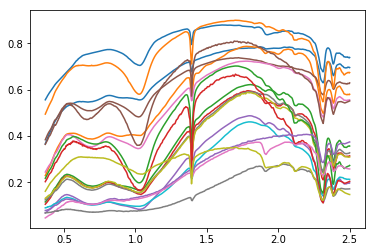

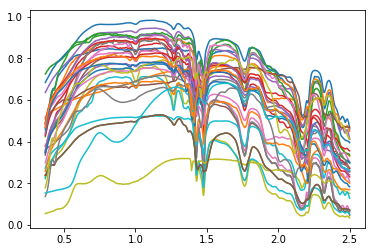

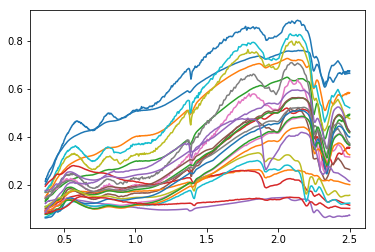

In [12]:
# --- plot the classes

# plot each class in a separate plot
# plot spectra names in legend
# plot minerals and mixtures w diff line widths

mineral_names = ["Actinolite", "Alunite", "Chlorite"]

# variables
num0 = 0 #number of samples of class 0
num1 = 0
num2 = 0

mineral_linewidth = 1         # linewidth = 1 is default
mixture_linewidth = 3         

# count the number of each class to make spectra0, spectra1, spectra2 databases
for i in range(num_samples):
    if y[i,0]== 0:
        num0 += 1
    elif y[i,0]== 1:
        num1 += 1
    elif y[i,0]== 2:
        num2 += 1

# make class-specific databases spectra0, ...1, ...2
spectra0 = np.zeros((num0,spectrum_len)) 
spectra1 = np.zeros((num1,spectrum_len)) 
spectra2 = np.zeros((num2,spectrum_len)) 

labels0 = ["" for x in range(num0)]
labels1 = ["" for x in range(num1)]
labels2 = ["" for x in range(num2)]

linewidth0 = np.zeros(num0)
linewidth1 = np.zeros(num1)
linewidth2 = np.zeros(num2)


# make counters for each database to place spectra
i0 = 0
i1 = 0
i2 = 0

# set linewidth for the spectrum 
# populate class-specific databases spectra0, ...1, ...2
for i in range(num_samples):
    
    # set linewidth
    #testcode
    #print(spectrum_categories)
    #print(spectrum_categories[i])
    
#     if spectrum_categories[i] == is_a_mineral:
#         linewidth = mineral_linewidth
        
#         #testcode
#         #print('min')
#     else: 
#         linewidth = mixture_linewidth
    linewidth = 2
        
        #testcode
        #print('mix')
    
    # populate matrices for making each class plot
    if y[i,0]== 0:
        spectra0[i0,:] = spectra[i,:]
        labels0[i0] = spectrum_names[i]
        linewidth0[i0] = linewidth
        i0 +=1
    elif y[i,0]== 1:
        spectra1[i1,:] = spectra[i,:]
        labels1[i1] = spectrum_names[i]
        linewidth1[i1] = linewidth
        i1 +=1
    else:
        spectra2[i2,:] = spectra[i,:]
        labels2[i2] = spectrum_names[i]
        linewidth2[i2] = linewidth
        i2 +=1

# plot each class-specific database separately
for i in range(i0):
#     fig = plt.figure()
#     plt.plot(range(1, spectrum_len+1), spectra0[i,:], label = labels0[i], linewidth = linewidth0[i]) # remove linewidth for all mixtures/minerals to be standard
    plt.plot(wavelengths[0,:], spectra0[i,:]) # remove linewidth for all mixtures/minerals to be standard
#     plt.xticks([])
#     plt.yticks([])
#     plt.show()
#     path = "/Users/Srikar/Desktop/Velexi/spectra-ml/lab-notebook/smunukutla/plots/" + mineral_names[0] + str(i) + ".png"
#     fig.savefig(path, format = "PNG")
# plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

for i in range(i1):
#     plt.plot(range(1, spectrum_len+1), spectra1[i,:], label = labels1[i], linewidth = linewidth1[i])
    plt.plot(wavelengths[0,:], spectra1[i,:])
# plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

for i in range(i2):
#     plt.plot(range(1, spectrum_len+1), spectra2[i,:], label = labels2[i], linewidth = linewidth2[i])
    plt.plot(wavelengths[0,:], spectra2[i,:])
# plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

In [13]:
sample_indices = list(range(0, num_samples))
print(num_samples)
random.shuffle(sample_indices)
train_set_size = 3*(num_samples//5)
dev_set_size = (num_samples//5)
test_set_size= num_samples-dev_set_size - train_set_size
print(train_set_size)
print(test_set_size)
print(dev_set_size)
train_set_indices = sample_indices[:train_set_size]
dev_set_indices = sample_indices[train_set_size: train_set_size+dev_set_size]
test_set_indices= sample_indices[train_set_size+dev_set_size: num_samples]
print(train_set_indices)
print(test_set_indices)
print(dev_set_indices)

train_set = spectra[train_set_indices, :]
train_labels = y[train_set_indices, :]
dev_set = spectra[dev_set_indices, :]
dev_labels = y[dev_set_indices, :]
test_set = spectra[test_set_indices, :]
test_labels = y[test_set_indices, :]

76
45
16
15
[52, 57, 65, 5, 35, 68, 34, 66, 45, 41, 13, 74, 27, 71, 50, 40, 46, 23, 32, 28, 3, 8, 30, 70, 1, 14, 56, 75, 11, 10, 61, 39, 63, 36, 7, 20, 22, 67, 2, 64, 6, 38, 0, 73, 58]
[55, 29, 43, 37, 51, 72, 42, 47, 17, 31, 15, 48, 44, 33, 19, 4]
[60, 59, 24, 12, 9, 26, 54, 53, 49, 62, 16, 21, 18, 25, 69]


In [14]:
train_labels = train_labels.flatten()
dev_labels = dev_labels.flatten()
test_labels = test_labels.flatten()
# type(train_labels)

In [15]:
# len(train_set)
# len(train_set[17])
print(test_set.shape)

(16, 1000)


In [16]:
train_set = np.reshape(train_set, (train_set.shape[0], spectrum_len, 1))
dev_set = np.reshape(dev_set, (dev_set.shape[0], spectrum_len, 1))
test_set = np.reshape(test_set, (test_set.shape[0], spectrum_len, 1))


print(train_labels)
train_labels = np.reshape(train_labels, (train_labels.shape[0], 1))
dev_labels = np.reshape(dev_labels, (dev_labels.shape[0], 1))
test_labels = np.reshape(test_labels, (test_labels.shape[0], 1))


train_labels = to_categorical(train_labels)
dev_labels = to_categorical(dev_labels)
test_labels = to_categorical(test_labels)

[1 1 2 0 2 2 2 2 1 0 0 1 1 2 1 0 1 1 2 1 0 0 2 2 0 0 1 1 0 0 2 2 2 2 0 1 1
 2 0 2 0 2 0 2 1]


In [17]:
#print(train_labels)

In [18]:
print(train_set.shape[1])


model = Sequential()
# model.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model.add(Conv1D(64, 25, activation='relu', input_shape=(train_set.shape[1], 1)))
model.add(Conv1D(64, 25, activation='relu'))
model.add(MaxPooling1D(4)) # 108 by 64 so far
model.add(Conv1D(100, 25, activation='relu'))
model.add(Conv1D(100, 25, activation='relu'))
model.add(MaxPooling1D(4))
# model.add(Dropout(0.5))
# model.add(GlobalAveragePooling1D())
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
print(model.summary())

1000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 976, 64)           1664      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 952, 64)           102464    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 238, 64)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 214, 100)          160100    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 190, 100)          250100    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 47, 100)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4700)              0         
_____

In [19]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 12
EPOCHS = 50

print(train_labels.shape)
#model.fit(train_set, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, \
            #verbose=1, validation_data=(dev_set, dev_labels))
History = model.fit(train_set, train_labels, batch_size=BATCH_SIZE, \
                    epochs=EPOCHS, verbose=1, validation_data=(dev_set, dev_labels)) 

(45, 3)
Train on 45 samples, validate on 15 samples
Epoch 1/50
45/45 [==============================] - 2s 44ms/step - loss: 1.1024 - acc: 0.3333 - val_loss: 0.9559 - val_acc: 0.4667
Epoch 2/50
45/45 [==============================] - 1s 23ms/step - loss: 0.9705 - acc: 0.4667 - val_loss: 0.5905 - val_acc: 0.8000
Epoch 3/50
45/45 [==============================] - 1s 23ms/step - loss: 0.6737 - acc: 0.6222 - val_loss: 0.3737 - val_acc: 0.8000
Epoch 4/50
45/45 [==============================] - 1s 24ms/step - loss: 0.4676 - acc: 0.7111 - val_loss: 0.4612 - val_acc: 0.8000
Epoch 5/50
45/45 [==============================] - 1s 26ms/step - loss: 0.8578 - acc: 0.7111 - val_loss: 0.3148 - val_acc: 0.8667
Epoch 6/50
45/45 [==============================] - 1s 23ms/step - loss: 0.4308 - acc: 0.7778 - val_loss: 0.4639 - val_acc: 0.8000
Epoch 7/50
45/45 [==============================] - 1s 23ms/step - loss: 0.5242 - acc: 0.7778 - val_loss: 0.4301 - val_acc: 0.8000
Epoch 8/50
45/45 [=============

In [20]:
y_pred = model.predict(test_set)
#y_pred

In [21]:
#test_labels

In [22]:
model.evaluate(test_set, test_labels)

16/16 [==============================] - 0s 6ms/step


[0.28822076320648193, 0.875]

In [23]:
# use bootstrap(model, data, data_labels, num_epochs, batch_size, num_bootstrap_runs)
num_epochs = EPOCHS
batch_size = BATCH_SIZE
num_bootstrap_runs = 100

##
train_set_labels = train_labels
dev_set_labels = dev_labels
#History = model.fit(train_set, train_set_labels, batch_size=BATCH_SIZE,\
         #epochs=EPOCHS, verbose=1, validation_data=(dev_set, dev_set_labels))
##

bresults = spectra_ml.metrics.bootstrap(model, spectra, y, num_epochs, batch_size, num_bootstrap_runs)
print(bresults)

Train on 46 samples, validate on 15 samples
Epoch 1/50
46/46 [==============================] - 1s 23ms/step - loss: 0.0517 - acc: 0.9783 - val_loss: 0.1076 - val_acc: 1.0000
Epoch 2/50
46/46 [==============================] - 1s 23ms/step - loss: 0.0416 - acc: 1.0000 - val_loss: 0.0397 - val_acc: 1.0000
Epoch 3/50
46/46 [==============================] - 1s 23ms/step - loss: 0.0217 - acc: 1.0000 - val_loss: 0.0410 - val_acc: 1.0000
Epoch 4/50
46/46 [==============================] - 1s 24ms/step - loss: 0.0150 - acc: 1.0000 - val_loss: 0.0845 - val_acc: 0.9333
Epoch 5/50
46/46 [==============================] - 1s 23ms/step - loss: 0.0155 - acc: 1.0000 - val_loss: 0.1357 - val_acc: 0.9333
Epoch 6/50
46/46 [==============================] - 1s 23ms/step - loss: 0.0074 - acc: 1.0000 - val_loss: 0.2054 - val_acc: 0.8667
Epoch 7/50
46/46 [==============================] - 1s 23ms/step - loss: 0.0063 - acc: 1.0000 - val_loss: 0.2484 - val_acc: 0.8667
Epoch 8/50
46/46 [=====================

46/46 [==============================] - 1s 26ms/step - loss: 0.2006 - acc: 0.9348 - val_loss: 2.1816 - val_acc: 0.8667
Epoch 12/50
46/46 [==============================] - 1s 25ms/step - loss: 0.0912 - acc: 0.9565 - val_loss: 0.7614 - val_acc: 0.9333
Epoch 13/50
46/46 [==============================] - 1s 25ms/step - loss: 0.2567 - acc: 0.8696 - val_loss: 0.5770 - val_acc: 0.8000
Epoch 14/50
46/46 [==============================] - 1s 25ms/step - loss: 0.1214 - acc: 0.9565 - val_loss: 0.1218 - val_acc: 0.9333
Epoch 15/50
46/46 [==============================] - 1s 26ms/step - loss: 0.0972 - acc: 0.9348 - val_loss: 0.7523 - val_acc: 0.8000
Epoch 16/50
46/46 [==============================] - 1s 26ms/step - loss: 0.1101 - acc: 0.9565 - val_loss: 0.5179 - val_acc: 0.8667
Epoch 17/50
46/46 [==============================] - 1s 25ms/step - loss: 0.0230 - acc: 1.0000 - val_loss: 0.6501 - val_acc: 0.8667
Epoch 18/50
46/46 [==============================] - 1s 26ms/step - loss: 0.0328 - acc: 

46/46 [==============================] - 1s 24ms/step - loss: 2.7249e-04 - acc: 1.0000 - val_loss: 2.1288 - val_acc: 0.8667
Epoch 22/50
46/46 [==============================] - 1s 24ms/step - loss: 2.6740e-04 - acc: 1.0000 - val_loss: 2.1346 - val_acc: 0.8667
Epoch 23/50
46/46 [==============================] - 1s 24ms/step - loss: 2.5778e-04 - acc: 1.0000 - val_loss: 2.1325 - val_acc: 0.8667
Epoch 24/50
46/46 [==============================] - 1s 23ms/step - loss: 2.5104e-04 - acc: 1.0000 - val_loss: 2.1301 - val_acc: 0.8667
Epoch 25/50
46/46 [==============================] - 1s 24ms/step - loss: 2.4529e-04 - acc: 1.0000 - val_loss: 2.1345 - val_acc: 0.8667
Epoch 26/50
46/46 [==============================] - 1s 24ms/step - loss: 2.3842e-04 - acc: 1.0000 - val_loss: 2.1395 - val_acc: 0.8667
Epoch 27/50
46/46 [==============================] - 1s 25ms/step - loss: 2.3233e-04 - acc: 1.0000 - val_loss: 2.1372 - val_acc: 0.8667
Epoch 28/50
46/46 [==============================] - 1s 25ms

46/46 [==============================] - 1s 24ms/step - loss: 8.6071e-05 - acc: 1.0000 - val_loss: 1.9013 - val_acc: 0.8667
Epoch 31/50
46/46 [==============================] - 1s 24ms/step - loss: 8.4341e-05 - acc: 1.0000 - val_loss: 1.9041 - val_acc: 0.8667
Epoch 32/50
46/46 [==============================] - 1s 24ms/step - loss: 8.3229e-05 - acc: 1.0000 - val_loss: 1.9100 - val_acc: 0.8667
Epoch 33/50
46/46 [==============================] - 1s 24ms/step - loss: 8.2276e-05 - acc: 1.0000 - val_loss: 1.9072 - val_acc: 0.8667
Epoch 34/50
46/46 [==============================] - 1s 24ms/step - loss: 8.0745e-05 - acc: 1.0000 - val_loss: 1.9096 - val_acc: 0.8667
Epoch 35/50
46/46 [==============================] - 1s 24ms/step - loss: 7.9487e-05 - acc: 1.0000 - val_loss: 1.9102 - val_acc: 0.8667
Epoch 36/50
46/46 [==============================] - 1s 24ms/step - loss: 7.8503e-05 - acc: 1.0000 - val_loss: 1.9126 - val_acc: 0.8667
Epoch 37/50
46/46 [==============================] - 1s 23ms

46/46 [==============================] - 1s 24ms/step - loss: 3.3854e-05 - acc: 1.0000 - val_loss: 2.0033 - val_acc: 0.8667
Epoch 40/50
46/46 [==============================] - 1s 24ms/step - loss: 3.3660e-05 - acc: 1.0000 - val_loss: 2.0074 - val_acc: 0.8667
Epoch 41/50
46/46 [==============================] - 1s 23ms/step - loss: 3.3264e-05 - acc: 1.0000 - val_loss: 2.0096 - val_acc: 0.8667
Epoch 42/50
46/46 [==============================] - 1s 24ms/step - loss: 3.3122e-05 - acc: 1.0000 - val_loss: 2.0128 - val_acc: 0.8667
Epoch 43/50
46/46 [==============================] - 1s 23ms/step - loss: 3.2900e-05 - acc: 1.0000 - val_loss: 2.0158 - val_acc: 0.8667
Epoch 44/50
46/46 [==============================] - 1s 24ms/step - loss: 3.2629e-05 - acc: 1.0000 - val_loss: 2.0187 - val_acc: 0.8667
Epoch 45/50
46/46 [==============================] - 1s 24ms/step - loss: 3.2330e-05 - acc: 1.0000 - val_loss: 2.0215 - val_acc: 0.8667
Epoch 46/50
46/46 [==============================] - 1s 23ms

46/46 [==============================] - 1s 23ms/step - loss: 2.9501e-05 - acc: 1.0000 - val_loss: 2.0282 - val_acc: 0.8667
Epoch 49/50
46/46 [==============================] - 1s 23ms/step - loss: 2.9277e-05 - acc: 1.0000 - val_loss: 2.0303 - val_acc: 0.8667
Epoch 50/50
15/15 [==============================] - 0s 6ms/step
Train on 46 samples, validate on 15 samples
Epoch 1/50
46/46 [==============================] - 1s 23ms/step - loss: 3.6552e-05 - acc: 1.0000 - val_loss: 2.0320 - val_acc: 0.8667
Epoch 2/50
46/46 [==============================] - 1s 23ms/step - loss: 3.6097e-05 - acc: 1.0000 - val_loss: 2.0381 - val_acc: 0.8667
Epoch 3/50
46/46 [==============================] - 1s 23ms/step - loss: 3.4823e-05 - acc: 1.0000 - val_loss: 2.0433 - val_acc: 0.8667
Epoch 4/50
46/46 [==============================] - 1s 23ms/step - loss: 3.3902e-05 - acc: 1.0000 - val_loss: 2.0483 - val_acc: 0.8667
Epoch 5/50
46/46 [==============================] - 1s 23ms/step - loss: 3.3218e-05 - acc: 

46/46 [==============================] - 1s 24ms/step - loss: 4.3012e-05 - acc: 1.0000 - val_loss: 2.1429 - val_acc: 0.8667
Epoch 8/50
46/46 [==============================] - 1s 24ms/step - loss: 4.2213e-05 - acc: 1.0000 - val_loss: 2.1506 - val_acc: 0.8667
Epoch 9/50
46/46 [==============================] - 1s 24ms/step - loss: 4.1559e-05 - acc: 1.0000 - val_loss: 2.1523 - val_acc: 0.8667
Epoch 10/50
46/46 [==============================] - 1s 24ms/step - loss: 4.0747e-05 - acc: 1.0000 - val_loss: 2.1524 - val_acc: 0.8667
Epoch 11/50
46/46 [==============================] - 1s 24ms/step - loss: 3.9932e-05 - acc: 1.0000 - val_loss: 2.1525 - val_acc: 0.8667
Epoch 12/50
46/46 [==============================] - 1s 24ms/step - loss: 3.8992e-05 - acc: 1.0000 - val_loss: 2.1525 - val_acc: 0.8667
Epoch 13/50
46/46 [==============================] - 1s 24ms/step - loss: 3.8451e-05 - acc: 1.0000 - val_loss: 2.1526 - val_acc: 0.8667
Epoch 14/50
46/46 [==============================] - 1s 24ms/s

Epoch 17/50
46/46 [==============================] - 1s 24ms/step - loss: 9.6409e-06 - acc: 1.0000 - val_loss: 2.1514 - val_acc: 0.8667
Epoch 18/50
46/46 [==============================] - 1s 24ms/step - loss: 9.4089e-06 - acc: 1.0000 - val_loss: 2.1513 - val_acc: 0.8667
Epoch 19/50
46/46 [==============================] - 1s 24ms/step - loss: 9.3182e-06 - acc: 1.0000 - val_loss: 2.1513 - val_acc: 0.8667
Epoch 20/50
46/46 [==============================] - 1s 24ms/step - loss: 9.1563e-06 - acc: 1.0000 - val_loss: 2.1513 - val_acc: 0.8667
Epoch 21/50
46/46 [==============================] - 1s 24ms/step - loss: 9.1485e-06 - acc: 1.0000 - val_loss: 2.1513 - val_acc: 0.8667
Epoch 22/50
46/46 [==============================] - 1s 24ms/step - loss: 8.9722e-06 - acc: 1.0000 - val_loss: 2.1512 - val_acc: 0.8667
Epoch 23/50
46/46 [==============================] - 1s 24ms/step - loss: 8.8439e-06 - acc: 1.0000 - val_loss: 2.1511 - val_acc: 0.8667
Epoch 24/50
46/46 [=============================

46/46 [==============================] - 1s 24ms/step - loss: 1.1315e-05 - acc: 1.0000 - val_loss: 2.1516 - val_acc: 0.8667
Epoch 27/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1060e-05 - acc: 1.0000 - val_loss: 2.1516 - val_acc: 0.8667
Epoch 28/50
46/46 [==============================] - 1s 24ms/step - loss: 1.0947e-05 - acc: 1.0000 - val_loss: 2.1515 - val_acc: 0.8667
Epoch 29/50
46/46 [==============================] - 1s 24ms/step - loss: 1.0764e-05 - acc: 1.0000 - val_loss: 2.1515 - val_acc: 0.8667
Epoch 30/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1029e-05 - acc: 1.0000 - val_loss: 2.1512 - val_acc: 0.8667
Epoch 31/50
46/46 [==============================] - 1s 24ms/step - loss: 1.0620e-05 - acc: 1.0000 - val_loss: 2.1513 - val_acc: 0.8667
Epoch 32/50
46/46 [==============================] - 1s 24ms/step - loss: 1.0370e-05 - acc: 1.0000 - val_loss: 2.1513 - val_acc: 0.8667
Epoch 33/50
46/46 [==============================] - 1s 24ms

46/46 [==============================] - 1s 24ms/step - loss: 9.1911e-06 - acc: 1.0000 - val_loss: 2.1509 - val_acc: 0.8667
Epoch 36/50
46/46 [==============================] - 1s 24ms/step - loss: 9.1678e-06 - acc: 1.0000 - val_loss: 2.1509 - val_acc: 0.8667
Epoch 37/50
46/46 [==============================] - 1s 24ms/step - loss: 9.0628e-06 - acc: 1.0000 - val_loss: 2.1508 - val_acc: 0.8667
Epoch 38/50
46/46 [==============================] - 1s 24ms/step - loss: 9.0110e-06 - acc: 1.0000 - val_loss: 2.1508 - val_acc: 0.8667
Epoch 39/50
46/46 [==============================] - 1s 24ms/step - loss: 8.9540e-06 - acc: 1.0000 - val_loss: 2.1508 - val_acc: 0.8667
Epoch 40/50
46/46 [==============================] - 1s 24ms/step - loss: 8.8943e-06 - acc: 1.0000 - val_loss: 2.1508 - val_acc: 0.8667
Epoch 41/50
46/46 [==============================] - 1s 24ms/step - loss: 8.8270e-06 - acc: 1.0000 - val_loss: 2.1509 - val_acc: 0.8667
Epoch 42/50
46/46 [==============================] - 1s 24ms

46/46 [==============================] - 1s 22ms/step - loss: 4.7063e-06 - acc: 1.0000 - val_loss: 2.1519 - val_acc: 0.8667
Epoch 45/50
46/46 [==============================] - 1s 23ms/step - loss: 4.7063e-06 - acc: 1.0000 - val_loss: 2.1519 - val_acc: 0.8667
Epoch 46/50
46/46 [==============================] - 1s 24ms/step - loss: 4.6830e-06 - acc: 1.0000 - val_loss: 2.1519 - val_acc: 0.8667
Epoch 47/50
46/46 [==============================] - 1s 23ms/step - loss: 4.7037e-06 - acc: 1.0000 - val_loss: 2.1518 - val_acc: 0.8667
Epoch 48/50
46/46 [==============================] - 1s 23ms/step - loss: 4.6480e-06 - acc: 1.0000 - val_loss: 2.1518 - val_acc: 0.8667
Epoch 49/50
46/46 [==============================] - 1s 23ms/step - loss: 4.6169e-06 - acc: 1.0000 - val_loss: 2.1518 - val_acc: 0.8667
Epoch 50/50
15/15 [==============================] - 0s 6ms/step
Train on 46 samples, validate on 15 samples
Epoch 1/50
46/46 [==============================] - 1s 23ms/step - loss: 5.3102e-06 - a

Epoch 3/50
46/46 [==============================] - 1s 24ms/step - loss: 7.0918e-06 - acc: 1.0000 - val_loss: 2.1510 - val_acc: 0.8667
Epoch 4/50
46/46 [==============================] - 1s 24ms/step - loss: 6.6992e-06 - acc: 1.0000 - val_loss: 2.1512 - val_acc: 0.8667
Epoch 5/50
46/46 [==============================] - 1s 24ms/step - loss: 6.2145e-06 - acc: 1.0000 - val_loss: 2.1514 - val_acc: 0.8667
Epoch 6/50
46/46 [==============================] - 1s 24ms/step - loss: 6.2392e-06 - acc: 1.0000 - val_loss: 2.1514 - val_acc: 0.8667
Epoch 7/50
46/46 [==============================] - 1s 24ms/step - loss: 6.2042e-06 - acc: 1.0000 - val_loss: 2.1513 - val_acc: 0.8667
Epoch 8/50
46/46 [==============================] - 1s 24ms/step - loss: 6.1096e-06 - acc: 1.0000 - val_loss: 2.1510 - val_acc: 0.8667
Epoch 9/50
46/46 [==============================] - 1s 24ms/step - loss: 5.9321e-06 - acc: 1.0000 - val_loss: 2.1510 - val_acc: 0.8667
Epoch 10/50
46/46 [==============================] - 1s

46/46 [==============================] - 1s 24ms/step - loss: 2.8637e-06 - acc: 1.0000 - val_loss: 2.1505 - val_acc: 0.8667
Epoch 13/50
46/46 [==============================] - 1s 24ms/step - loss: 2.8183e-06 - acc: 1.0000 - val_loss: 2.1504 - val_acc: 0.8667
Epoch 14/50
46/46 [==============================] - 1s 24ms/step - loss: 2.8274e-06 - acc: 1.0000 - val_loss: 2.1504 - val_acc: 0.8667
Epoch 15/50
46/46 [==============================] - 1s 24ms/step - loss: 2.8792e-06 - acc: 1.0000 - val_loss: 2.1505 - val_acc: 0.8667
Epoch 16/50
46/46 [==============================] - 1s 24ms/step - loss: 2.7989e-06 - acc: 1.0000 - val_loss: 2.1503 - val_acc: 0.8667
Epoch 17/50
46/46 [==============================] - 1s 24ms/step - loss: 2.7535e-06 - acc: 1.0000 - val_loss: 2.1503 - val_acc: 0.8667
Epoch 18/50
46/46 [==============================] - 1s 24ms/step - loss: 2.7535e-06 - acc: 1.0000 - val_loss: 2.1503 - val_acc: 0.8667
Epoch 19/50
46/46 [==============================] - 1s 24ms

46/46 [==============================] - 1s 24ms/step - loss: 1.9735e-06 - acc: 1.0000 - val_loss: 2.1499 - val_acc: 0.8667
Epoch 22/50
46/46 [==============================] - 1s 24ms/step - loss: 1.9696e-06 - acc: 1.0000 - val_loss: 2.1498 - val_acc: 0.8667
Epoch 23/50
46/46 [==============================] - 1s 24ms/step - loss: 1.9514e-06 - acc: 1.0000 - val_loss: 2.1498 - val_acc: 0.8667
Epoch 24/50
46/46 [==============================] - 1s 24ms/step - loss: 1.9670e-06 - acc: 1.0000 - val_loss: 2.1498 - val_acc: 0.8667
Epoch 25/50
46/46 [==============================] - 1s 24ms/step - loss: 1.9411e-06 - acc: 1.0000 - val_loss: 2.1498 - val_acc: 0.8667
Epoch 26/50
46/46 [==============================] - 1s 24ms/step - loss: 1.9294e-06 - acc: 1.0000 - val_loss: 2.1498 - val_acc: 0.8667
Epoch 27/50
46/46 [==============================] - 1s 24ms/step - loss: 1.9242e-06 - acc: 1.0000 - val_loss: 2.1498 - val_acc: 0.8667
Epoch 28/50
46/46 [==============================] - 1s 25ms

46/46 [==============================] - 1s 24ms/step - loss: 3.5219e-06 - acc: 1.0000 - val_loss: 2.1508 - val_acc: 0.8667
Epoch 31/50
46/46 [==============================] - 1s 24ms/step - loss: 3.4843e-06 - acc: 1.0000 - val_loss: 2.1510 - val_acc: 0.8667
Epoch 32/50
46/46 [==============================] - 1s 24ms/step - loss: 3.4428e-06 - acc: 1.0000 - val_loss: 2.1511 - val_acc: 0.8667
Epoch 33/50
46/46 [==============================] - 1s 24ms/step - loss: 3.4079e-06 - acc: 1.0000 - val_loss: 2.1511 - val_acc: 0.8667
Epoch 34/50
46/46 [==============================] - 1s 24ms/step - loss: 3.3962e-06 - acc: 1.0000 - val_loss: 2.1509 - val_acc: 0.8667
Epoch 35/50
46/46 [==============================] - 1s 24ms/step - loss: 3.3612e-06 - acc: 1.0000 - val_loss: 2.1509 - val_acc: 0.8667
Epoch 36/50
46/46 [==============================] - 1s 25ms/step - loss: 3.3599e-06 - acc: 1.0000 - val_loss: 2.1509 - val_acc: 0.8667
Epoch 37/50
46/46 [==============================] - 1s 24ms

46/46 [==============================] - 1s 24ms/step - loss: 5.4422e-07 - acc: 1.0000 - val_loss: 2.1514 - val_acc: 0.8667
Epoch 40/50
46/46 [==============================] - 1s 25ms/step - loss: 5.4681e-07 - acc: 1.0000 - val_loss: 2.1515 - val_acc: 0.8667
Epoch 41/50
46/46 [==============================] - 1s 24ms/step - loss: 5.3904e-07 - acc: 1.0000 - val_loss: 2.1515 - val_acc: 0.8667
Epoch 42/50
46/46 [==============================] - 1s 24ms/step - loss: 5.3644e-07 - acc: 1.0000 - val_loss: 2.1515 - val_acc: 0.8667
Epoch 43/50
46/46 [==============================] - 1s 24ms/step - loss: 5.4292e-07 - acc: 1.0000 - val_loss: 2.1514 - val_acc: 0.8667
Epoch 44/50
46/46 [==============================] - 1s 24ms/step - loss: 5.4163e-07 - acc: 1.0000 - val_loss: 2.1515 - val_acc: 0.8667
Epoch 45/50
46/46 [==============================] - 1s 24ms/step - loss: 5.3774e-07 - acc: 1.0000 - val_loss: 2.1515 - val_acc: 0.8667
Epoch 46/50
46/46 [==============================] - 1s 25ms

46/46 [==============================] - 1s 25ms/step - loss: 1.6832e-06 - acc: 1.0000 - val_loss: 2.1500 - val_acc: 0.8667
Epoch 49/50
46/46 [==============================] - 1s 25ms/step - loss: 1.6663e-06 - acc: 1.0000 - val_loss: 2.1500 - val_acc: 0.8667
Epoch 50/50
15/15 [==============================] - 0s 6ms/step
Train on 46 samples, validate on 15 samples
Epoch 1/50
46/46 [==============================] - 1s 24ms/step - loss: 3.6048e-06 - acc: 1.0000 - val_loss: 2.1503 - val_acc: 0.8667
Epoch 2/50
46/46 [==============================] - 1s 24ms/step - loss: 3.0334e-06 - acc: 1.0000 - val_loss: 2.1510 - val_acc: 0.8667
Epoch 3/50
46/46 [==============================] - 1s 24ms/step - loss: 2.6563e-06 - acc: 1.0000 - val_loss: 2.1518 - val_acc: 0.8667
Epoch 4/50
46/46 [==============================] - 1s 24ms/step - loss: 2.7444e-06 - acc: 1.0000 - val_loss: 2.1521 - val_acc: 0.8667
Epoch 5/50
46/46 [==============================] - 1s 24ms/step - loss: 2.8027e-06 - acc: 

46/46 [==============================] - 1s 24ms/step - loss: 1.4487e-06 - acc: 1.0000 - val_loss: 2.1495 - val_acc: 0.8667
Epoch 8/50
46/46 [==============================] - 1s 24ms/step - loss: 1.4538e-06 - acc: 1.0000 - val_loss: 2.1495 - val_acc: 0.8667
Epoch 9/50
46/46 [==============================] - 1s 24ms/step - loss: 1.4513e-06 - acc: 1.0000 - val_loss: 2.1495 - val_acc: 0.8667
Epoch 10/50
46/46 [==============================] - 1s 24ms/step - loss: 1.4279e-06 - acc: 1.0000 - val_loss: 2.1495 - val_acc: 0.8667
Epoch 11/50
46/46 [==============================] - 1s 24ms/step - loss: 1.3994e-06 - acc: 1.0000 - val_loss: 2.1494 - val_acc: 0.8667
Epoch 12/50
46/46 [==============================] - 1s 24ms/step - loss: 1.4020e-06 - acc: 1.0000 - val_loss: 2.1494 - val_acc: 0.8667
Epoch 13/50
46/46 [==============================] - 1s 24ms/step - loss: 1.3955e-06 - acc: 1.0000 - val_loss: 2.1494 - val_acc: 0.8667
Epoch 14/50
46/46 [==============================] - 1s 24ms/s

Epoch 17/50
46/46 [==============================] - 1s 24ms/step - loss: 8.7075e-07 - acc: 1.0000 - val_loss: 2.1495 - val_acc: 0.8667
Epoch 18/50
46/46 [==============================] - 1s 25ms/step - loss: 8.6038e-07 - acc: 1.0000 - val_loss: 2.1495 - val_acc: 0.8667
Epoch 19/50
46/46 [==============================] - 1s 24ms/step - loss: 8.5650e-07 - acc: 1.0000 - val_loss: 2.1495 - val_acc: 0.8667
Epoch 20/50
46/46 [==============================] - 1s 24ms/step - loss: 8.5520e-07 - acc: 1.0000 - val_loss: 2.1495 - val_acc: 0.8667
Epoch 21/50
46/46 [==============================] - 1s 24ms/step - loss: 8.5002e-07 - acc: 1.0000 - val_loss: 2.1495 - val_acc: 0.8667
Epoch 22/50
46/46 [==============================] - 1s 24ms/step - loss: 8.4743e-07 - acc: 1.0000 - val_loss: 2.1495 - val_acc: 0.8667
Epoch 23/50
46/46 [==============================] - 1s 24ms/step - loss: 8.4354e-07 - acc: 1.0000 - val_loss: 2.1495 - val_acc: 0.8667
Epoch 24/50
46/46 [=============================

46/46 [==============================] - 1s 24ms/step - loss: 6.1548e-07 - acc: 1.0000 - val_loss: 2.1499 - val_acc: 0.8667
Epoch 27/50
46/46 [==============================] - 1s 24ms/step - loss: 6.1548e-07 - acc: 1.0000 - val_loss: 2.1500 - val_acc: 0.8667
Epoch 28/50
46/46 [==============================] - 1s 24ms/step - loss: 6.0901e-07 - acc: 1.0000 - val_loss: 2.1500 - val_acc: 0.8667
Epoch 29/50
46/46 [==============================] - 1s 24ms/step - loss: 6.0901e-07 - acc: 1.0000 - val_loss: 2.1499 - val_acc: 0.8667
Epoch 30/50
46/46 [==============================] - 1s 24ms/step - loss: 5.9994e-07 - acc: 1.0000 - val_loss: 2.1500 - val_acc: 0.8667
Epoch 31/50
46/46 [==============================] - 1s 24ms/step - loss: 6.0512e-07 - acc: 1.0000 - val_loss: 2.1500 - val_acc: 0.8667
Epoch 32/50
46/46 [==============================] - 1s 24ms/step - loss: 5.9994e-07 - acc: 1.0000 - val_loss: 2.1500 - val_acc: 0.8667
Epoch 33/50
46/46 [==============================] - 1s 24ms

46/46 [==============================] - 1s 24ms/step - loss: 1.4007e-06 - acc: 1.0000 - val_loss: 2.1498 - val_acc: 0.8667
Epoch 36/50
46/46 [==============================] - 1s 24ms/step - loss: 1.3852e-06 - acc: 1.0000 - val_loss: 2.1498 - val_acc: 0.8667
Epoch 37/50
46/46 [==============================] - 1s 24ms/step - loss: 1.3722e-06 - acc: 1.0000 - val_loss: 2.1498 - val_acc: 0.8667
Epoch 38/50
46/46 [==============================] - 1s 24ms/step - loss: 1.3631e-06 - acc: 1.0000 - val_loss: 2.1498 - val_acc: 0.8667
Epoch 39/50
46/46 [==============================] - 1s 24ms/step - loss: 1.3541e-06 - acc: 1.0000 - val_loss: 2.1499 - val_acc: 0.8667
Epoch 40/50
46/46 [==============================] - 1s 24ms/step - loss: 1.3463e-06 - acc: 1.0000 - val_loss: 2.1499 - val_acc: 0.8667
Epoch 41/50
46/46 [==============================] - 1s 24ms/step - loss: 1.3320e-06 - acc: 1.0000 - val_loss: 2.1498 - val_acc: 0.8667
Epoch 42/50
46/46 [==============================] - 1s 24ms

46/46 [==============================] - 1s 24ms/step - loss: 1.7881e-07 - acc: 1.0000 - val_loss: 2.1492 - val_acc: 0.8667
Epoch 45/50
46/46 [==============================] - 1s 24ms/step - loss: 1.7881e-07 - acc: 1.0000 - val_loss: 2.1492 - val_acc: 0.8667
Epoch 46/50
46/46 [==============================] - 1s 24ms/step - loss: 1.7881e-07 - acc: 1.0000 - val_loss: 2.1492 - val_acc: 0.8667
Epoch 47/50
46/46 [==============================] - 1s 24ms/step - loss: 1.7881e-07 - acc: 1.0000 - val_loss: 2.1492 - val_acc: 0.8667
Epoch 48/50
46/46 [==============================] - 1s 25ms/step - loss: 1.7881e-07 - acc: 1.0000 - val_loss: 2.1492 - val_acc: 0.8667
Epoch 49/50
46/46 [==============================] - 1s 24ms/step - loss: 1.7881e-07 - acc: 1.0000 - val_loss: 2.1492 - val_acc: 0.8667
Epoch 50/50
15/15 [==============================] - 0s 6ms/step
Train on 46 samples, validate on 15 samples
Epoch 1/50
46/46 [==============================] - 1s 24ms/step - loss: 9.6105e-05 - a

Epoch 3/50
46/46 [==============================] - 1s 24ms/step - loss: 1.2605e-05 - acc: 1.0000 - val_loss: 1.3673 - val_acc: 0.8667
Epoch 4/50
46/46 [==============================] - 1s 24ms/step - loss: 1.0631e-05 - acc: 1.0000 - val_loss: 1.4373 - val_acc: 0.8667
Epoch 5/50
46/46 [==============================] - 1s 24ms/step - loss: 8.3403e-06 - acc: 1.0000 - val_loss: 1.5032 - val_acc: 0.8667
Epoch 6/50
46/46 [==============================] - 1s 24ms/step - loss: 7.2477e-06 - acc: 1.0000 - val_loss: 1.5586 - val_acc: 0.8667
Epoch 7/50
46/46 [==============================] - 1s 24ms/step - loss: 6.8459e-06 - acc: 1.0000 - val_loss: 1.6010 - val_acc: 0.8667
Epoch 8/50
46/46 [==============================] - 1s 25ms/step - loss: 5.9673e-06 - acc: 1.0000 - val_loss: 1.6274 - val_acc: 0.8667
Epoch 9/50
46/46 [==============================] - 1s 27ms/step - loss: 5.5228e-06 - acc: 1.0000 - val_loss: 1.6472 - val_acc: 0.8667
Epoch 10/50
46/46 [==============================] - 1s

46/46 [==============================] - 1s 24ms/step - loss: 1.5497e-06 - acc: 1.0000 - val_loss: 2.0946 - val_acc: 0.8667
Epoch 13/50
46/46 [==============================] - 1s 24ms/step - loss: 1.5303e-06 - acc: 1.0000 - val_loss: 2.0997 - val_acc: 0.8667
Epoch 14/50
46/46 [==============================] - 1s 23ms/step - loss: 1.5225e-06 - acc: 1.0000 - val_loss: 2.1061 - val_acc: 0.8667
Epoch 15/50
46/46 [==============================] - 1s 23ms/step - loss: 1.5057e-06 - acc: 1.0000 - val_loss: 2.1112 - val_acc: 0.8667
Epoch 16/50
46/46 [==============================] - 1s 24ms/step - loss: 1.4966e-06 - acc: 1.0000 - val_loss: 2.1163 - val_acc: 0.8667
Epoch 17/50
46/46 [==============================] - 1s 23ms/step - loss: 1.4759e-06 - acc: 1.0000 - val_loss: 2.1205 - val_acc: 0.8667
Epoch 18/50
46/46 [==============================] - 1s 24ms/step - loss: 1.4707e-06 - acc: 1.0000 - val_loss: 2.1261 - val_acc: 0.8667
Epoch 19/50
46/46 [==============================] - 1s 23ms

46/46 [==============================] - 1s 25ms/step - loss: 1.1701e-06 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 22/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1610e-06 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 23/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1467e-06 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 24/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1454e-06 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 25/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1299e-06 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 26/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1260e-06 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 27/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1131e-06 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 28/50
46/46 [==============================] - 1s 24ms

46/46 [==============================] - 1s 25ms/step - loss: 6.8934e-07 - acc: 1.0000 - val_loss: 2.1506 - val_acc: 0.8667
Epoch 31/50
46/46 [==============================] - 1s 24ms/step - loss: 6.8805e-07 - acc: 1.0000 - val_loss: 2.1506 - val_acc: 0.8667
Epoch 32/50
46/46 [==============================] - 1s 25ms/step - loss: 6.8416e-07 - acc: 1.0000 - val_loss: 2.1506 - val_acc: 0.8667
Epoch 33/50
46/46 [==============================] - 1s 25ms/step - loss: 6.8416e-07 - acc: 1.0000 - val_loss: 2.1506 - val_acc: 0.8667
Epoch 34/50
46/46 [==============================] - 1s 25ms/step - loss: 6.7768e-07 - acc: 1.0000 - val_loss: 2.1506 - val_acc: 0.8667
Epoch 35/50
46/46 [==============================] - 1s 24ms/step - loss: 6.7509e-07 - acc: 1.0000 - val_loss: 2.1506 - val_acc: 0.8667
Epoch 36/50
46/46 [==============================] - 1s 24ms/step - loss: 6.7379e-07 - acc: 1.0000 - val_loss: 2.1506 - val_acc: 0.8667
Epoch 37/50
46/46 [==============================] - 1s 25ms

46/46 [==============================] - 1s 25ms/step - loss: 8.4742e-07 - acc: 1.0000 - val_loss: 2.1510 - val_acc: 0.8667
Epoch 40/50
46/46 [==============================] - 1s 25ms/step - loss: 8.3965e-07 - acc: 1.0000 - val_loss: 2.1510 - val_acc: 0.8667
Epoch 41/50
46/46 [==============================] - 1s 25ms/step - loss: 8.3576e-07 - acc: 1.0000 - val_loss: 2.1511 - val_acc: 0.8667
Epoch 42/50
46/46 [==============================] - 1s 25ms/step - loss: 8.3317e-07 - acc: 1.0000 - val_loss: 2.1511 - val_acc: 0.8667
Epoch 43/50
46/46 [==============================] - 1s 25ms/step - loss: 8.2799e-07 - acc: 1.0000 - val_loss: 2.1511 - val_acc: 0.8667
Epoch 44/50
46/46 [==============================] - 1s 25ms/step - loss: 8.2410e-07 - acc: 1.0000 - val_loss: 2.1511 - val_acc: 0.8667
Epoch 45/50
46/46 [==============================] - 1s 25ms/step - loss: 8.2021e-07 - acc: 1.0000 - val_loss: 2.1512 - val_acc: 0.8667
Epoch 46/50
46/46 [==============================] - 1s 25ms

46/46 [==============================] - 1s 25ms/step - loss: 3.9780e-07 - acc: 1.0000 - val_loss: 2.1541 - val_acc: 0.8667
Epoch 49/50
46/46 [==============================] - 1s 25ms/step - loss: 3.9521e-07 - acc: 1.0000 - val_loss: 2.1541 - val_acc: 0.8667
Epoch 50/50
15/15 [==============================] - 0s 6ms/step
Train on 46 samples, validate on 15 samples
Epoch 1/50
46/46 [==============================] - 1s 25ms/step - loss: 1.5381e-06 - acc: 1.0000 - val_loss: 2.1539 - val_acc: 0.8667
Epoch 2/50
46/46 [==============================] - 1s 25ms/step - loss: 1.4525e-06 - acc: 1.0000 - val_loss: 2.1534 - val_acc: 0.8667
Epoch 3/50
46/46 [==============================] - 1s 25ms/step - loss: 1.3320e-06 - acc: 1.0000 - val_loss: 2.1528 - val_acc: 0.8667
Epoch 4/50
46/46 [==============================] - 1s 25ms/step - loss: 1.2284e-06 - acc: 1.0000 - val_loss: 2.1523 - val_acc: 0.8667
Epoch 5/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1454e-06 - acc: 

46/46 [==============================] - 1s 24ms/step - loss: 4.5611e-07 - acc: 1.0000 - val_loss: 2.1505 - val_acc: 0.8667
Epoch 8/50
46/46 [==============================] - 1s 24ms/step - loss: 4.4963e-07 - acc: 1.0000 - val_loss: 2.1506 - val_acc: 0.8667
Epoch 9/50
46/46 [==============================] - 1s 24ms/step - loss: 4.4444e-07 - acc: 1.0000 - val_loss: 2.1506 - val_acc: 0.8667
Epoch 10/50
46/46 [==============================] - 1s 24ms/step - loss: 4.4185e-07 - acc: 1.0000 - val_loss: 2.1507 - val_acc: 0.8667
Epoch 11/50
46/46 [==============================] - 1s 24ms/step - loss: 4.3667e-07 - acc: 1.0000 - val_loss: 2.1508 - val_acc: 0.8667
Epoch 12/50
46/46 [==============================] - 1s 24ms/step - loss: 4.3149e-07 - acc: 1.0000 - val_loss: 2.1508 - val_acc: 0.8667
Epoch 13/50
46/46 [==============================] - 1s 24ms/step - loss: 4.2889e-07 - acc: 1.0000 - val_loss: 2.1508 - val_acc: 0.8667
Epoch 14/50
46/46 [==============================] - 1s 24ms/s

Epoch 17/50
46/46 [==============================] - 1s 25ms/step - loss: 5.5977e-07 - acc: 1.0000 - val_loss: 2.1505 - val_acc: 0.8667
Epoch 18/50
46/46 [==============================] - 1s 24ms/step - loss: 5.5847e-07 - acc: 1.0000 - val_loss: 2.1504 - val_acc: 0.8667
Epoch 19/50
46/46 [==============================] - 1s 24ms/step - loss: 5.5717e-07 - acc: 1.0000 - val_loss: 2.1504 - val_acc: 0.8667
Epoch 20/50
46/46 [==============================] - 1s 24ms/step - loss: 5.4940e-07 - acc: 1.0000 - val_loss: 2.1504 - val_acc: 0.8667
Epoch 21/50
46/46 [==============================] - 1s 24ms/step - loss: 5.4681e-07 - acc: 1.0000 - val_loss: 2.1504 - val_acc: 0.8667
Epoch 22/50
46/46 [==============================] - 1s 25ms/step - loss: 5.4551e-07 - acc: 1.0000 - val_loss: 2.1504 - val_acc: 0.8667
Epoch 23/50
46/46 [==============================] - 1s 24ms/step - loss: 5.4292e-07 - acc: 1.0000 - val_loss: 2.1504 - val_acc: 0.8667
Epoch 24/50
46/46 [=============================

46/46 [==============================] - 1s 24ms/step - loss: 5.7920e-07 - acc: 1.0000 - val_loss: 2.1501 - val_acc: 0.8667
Epoch 27/50
46/46 [==============================] - 1s 25ms/step - loss: 5.7920e-07 - acc: 1.0000 - val_loss: 2.1501 - val_acc: 0.8667
Epoch 28/50
46/46 [==============================] - 1s 25ms/step - loss: 5.7143e-07 - acc: 1.0000 - val_loss: 2.1501 - val_acc: 0.8667
Epoch 29/50
46/46 [==============================] - 1s 24ms/step - loss: 5.6495e-07 - acc: 1.0000 - val_loss: 2.1501 - val_acc: 0.8667
Epoch 30/50
46/46 [==============================] - 1s 24ms/step - loss: 5.6365e-07 - acc: 1.0000 - val_loss: 2.1501 - val_acc: 0.8667
Epoch 31/50
46/46 [==============================] - 1s 24ms/step - loss: 5.5458e-07 - acc: 1.0000 - val_loss: 2.1501 - val_acc: 0.8667
Epoch 32/50
46/46 [==============================] - 1s 25ms/step - loss: 5.5458e-07 - acc: 1.0000 - val_loss: 2.1501 - val_acc: 0.8667
Epoch 33/50
46/46 [==============================] - 1s 24ms

46/46 [==============================] - 1s 25ms/step - loss: 2.1250e-07 - acc: 1.0000 - val_loss: 2.1514 - val_acc: 0.8667
Epoch 36/50
46/46 [==============================] - 1s 25ms/step - loss: 2.1250e-07 - acc: 1.0000 - val_loss: 2.1515 - val_acc: 0.8667
Epoch 37/50
46/46 [==============================] - 1s 25ms/step - loss: 2.1250e-07 - acc: 1.0000 - val_loss: 2.1515 - val_acc: 0.8667
Epoch 38/50
46/46 [==============================] - 1s 26ms/step - loss: 2.1250e-07 - acc: 1.0000 - val_loss: 2.1515 - val_acc: 0.8667
Epoch 39/50
46/46 [==============================] - 1s 25ms/step - loss: 2.1250e-07 - acc: 1.0000 - val_loss: 2.1515 - val_acc: 0.8667
Epoch 40/50
46/46 [==============================] - 1s 25ms/step - loss: 2.1250e-07 - acc: 1.0000 - val_loss: 2.1515 - val_acc: 0.8667
Epoch 41/50
46/46 [==============================] - 1s 25ms/step - loss: 2.0602e-07 - acc: 1.0000 - val_loss: 2.1516 - val_acc: 0.8667
Epoch 42/50
46/46 [==============================] - 1s 24ms

46/46 [==============================] - 1s 24ms/step - loss: 3.3042e-07 - acc: 1.0000 - val_loss: 2.1511 - val_acc: 0.8667
Epoch 45/50
46/46 [==============================] - 1s 24ms/step - loss: 3.3042e-07 - acc: 1.0000 - val_loss: 2.1511 - val_acc: 0.8667
Epoch 46/50
46/46 [==============================] - 1s 25ms/step - loss: 3.3042e-07 - acc: 1.0000 - val_loss: 2.1511 - val_acc: 0.8667
Epoch 47/50
46/46 [==============================] - 1s 24ms/step - loss: 3.3042e-07 - acc: 1.0000 - val_loss: 2.1511 - val_acc: 0.8667
Epoch 48/50
46/46 [==============================] - 1s 24ms/step - loss: 3.2912e-07 - acc: 1.0000 - val_loss: 2.1511 - val_acc: 0.8667
Epoch 49/50
46/46 [==============================] - 1s 24ms/step - loss: 3.2912e-07 - acc: 1.0000 - val_loss: 2.1511 - val_acc: 0.8667
Epoch 50/50
15/15 [==============================] - 0s 6ms/step
Train on 46 samples, validate on 15 samples
Epoch 1/50
46/46 [==============================] - 1s 24ms/step - loss: 2.9932e-07 - a

Epoch 3/50
46/46 [==============================] - 1s 24ms/step - loss: 3.2005e-07 - acc: 1.0000 - val_loss: 2.1520 - val_acc: 0.8667
Epoch 4/50
46/46 [==============================] - 1s 24ms/step - loss: 3.1876e-07 - acc: 1.0000 - val_loss: 2.1520 - val_acc: 0.8667
Epoch 5/50
46/46 [==============================] - 1s 25ms/step - loss: 3.1487e-07 - acc: 1.0000 - val_loss: 2.1519 - val_acc: 0.8667
Epoch 6/50
46/46 [==============================] - 1s 25ms/step - loss: 3.0969e-07 - acc: 1.0000 - val_loss: 2.1518 - val_acc: 0.8667
Epoch 7/50
46/46 [==============================] - 1s 25ms/step - loss: 3.0709e-07 - acc: 1.0000 - val_loss: 2.1518 - val_acc: 0.8667
Epoch 8/50
46/46 [==============================] - 1s 24ms/step - loss: 3.0580e-07 - acc: 1.0000 - val_loss: 2.1517 - val_acc: 0.8667
Epoch 9/50
46/46 [==============================] - 1s 25ms/step - loss: 3.0839e-07 - acc: 1.0000 - val_loss: 2.1517 - val_acc: 0.8667
Epoch 10/50
46/46 [==============================] - 1s

46/46 [==============================] - 1s 24ms/step - loss: 2.7988e-07 - acc: 1.0000 - val_loss: 2.1508 - val_acc: 0.8667
Epoch 13/50
46/46 [==============================] - 1s 26ms/step - loss: 2.7729e-07 - acc: 1.0000 - val_loss: 2.1508 - val_acc: 0.8667
Epoch 14/50
46/46 [==============================] - 1s 24ms/step - loss: 2.7600e-07 - acc: 1.0000 - val_loss: 2.1507 - val_acc: 0.8667
Epoch 15/50
46/46 [==============================] - 1s 24ms/step - loss: 2.6952e-07 - acc: 1.0000 - val_loss: 2.1507 - val_acc: 0.8667
Epoch 16/50
46/46 [==============================] - 1s 24ms/step - loss: 2.7081e-07 - acc: 1.0000 - val_loss: 2.1506 - val_acc: 0.8667
Epoch 17/50
46/46 [==============================] - 1s 24ms/step - loss: 2.6822e-07 - acc: 1.0000 - val_loss: 2.1506 - val_acc: 0.8667
Epoch 18/50
46/46 [==============================] - 1s 24ms/step - loss: 2.6433e-07 - acc: 1.0000 - val_loss: 2.1505 - val_acc: 0.8667
Epoch 19/50
46/46 [==============================] - 1s 24ms

46/46 [==============================] - 1s 24ms/step - loss: 2.7729e-07 - acc: 1.0000 - val_loss: 2.1500 - val_acc: 0.8667
Epoch 22/50
46/46 [==============================] - 1s 24ms/step - loss: 2.7600e-07 - acc: 1.0000 - val_loss: 2.1500 - val_acc: 0.8667
Epoch 23/50
46/46 [==============================] - 1s 24ms/step - loss: 2.7600e-07 - acc: 1.0000 - val_loss: 2.1500 - val_acc: 0.8667
Epoch 24/50
46/46 [==============================] - 1s 24ms/step - loss: 2.7600e-07 - acc: 1.0000 - val_loss: 2.1500 - val_acc: 0.8667
Epoch 25/50
46/46 [==============================] - 1s 24ms/step - loss: 2.7340e-07 - acc: 1.0000 - val_loss: 2.1500 - val_acc: 0.8667
Epoch 26/50
46/46 [==============================] - 1s 24ms/step - loss: 2.7211e-07 - acc: 1.0000 - val_loss: 2.1500 - val_acc: 0.8667
Epoch 27/50
46/46 [==============================] - 1s 24ms/step - loss: 2.6952e-07 - acc: 1.0000 - val_loss: 2.1500 - val_acc: 0.8667
Epoch 28/50
46/46 [==============================] - 1s 24ms

46/46 [==============================] - 1s 24ms/step - loss: 2.0214e-07 - acc: 1.0000 - val_loss: 2.1502 - val_acc: 0.8667
Epoch 31/50
46/46 [==============================] - 1s 25ms/step - loss: 2.0214e-07 - acc: 1.0000 - val_loss: 2.1502 - val_acc: 0.8667
Epoch 32/50
46/46 [==============================] - 1s 24ms/step - loss: 2.0214e-07 - acc: 1.0000 - val_loss: 2.1502 - val_acc: 0.8667
Epoch 33/50
46/46 [==============================] - 1s 24ms/step - loss: 2.0214e-07 - acc: 1.0000 - val_loss: 2.1502 - val_acc: 0.8667
Epoch 34/50
46/46 [==============================] - 1s 24ms/step - loss: 2.0214e-07 - acc: 1.0000 - val_loss: 2.1502 - val_acc: 0.8667
Epoch 35/50
46/46 [==============================] - 1s 24ms/step - loss: 2.0214e-07 - acc: 1.0000 - val_loss: 2.1502 - val_acc: 0.8667
Epoch 36/50
46/46 [==============================] - 1s 24ms/step - loss: 2.0214e-07 - acc: 1.0000 - val_loss: 2.1502 - val_acc: 0.8667
Epoch 37/50
46/46 [==============================] - 1s 24ms

46/46 [==============================] - 1s 24ms/step - loss: 1.7881e-07 - acc: 1.0000 - val_loss: 2.1506 - val_acc: 0.8667
Epoch 40/50
46/46 [==============================] - 1s 25ms/step - loss: 1.7881e-07 - acc: 1.0000 - val_loss: 2.1506 - val_acc: 0.8667
Epoch 41/50
46/46 [==============================] - 1s 24ms/step - loss: 1.7881e-07 - acc: 1.0000 - val_loss: 2.1507 - val_acc: 0.8667
Epoch 42/50
46/46 [==============================] - 1s 24ms/step - loss: 1.7881e-07 - acc: 1.0000 - val_loss: 2.1507 - val_acc: 0.8667
Epoch 43/50
46/46 [==============================] - 1s 24ms/step - loss: 1.7881e-07 - acc: 1.0000 - val_loss: 2.1507 - val_acc: 0.8667
Epoch 44/50
46/46 [==============================] - 1s 24ms/step - loss: 1.7881e-07 - acc: 1.0000 - val_loss: 2.1507 - val_acc: 0.8667
Epoch 45/50
46/46 [==============================] - 1s 24ms/step - loss: 1.7881e-07 - acc: 1.0000 - val_loss: 2.1507 - val_acc: 0.8667
Epoch 46/50
46/46 [==============================] - 1s 24ms

46/46 [==============================] - 1s 23ms/step - loss: 1.8400e-07 - acc: 1.0000 - val_loss: 2.1509 - val_acc: 0.8667
Epoch 49/50
46/46 [==============================] - 1s 25ms/step - loss: 1.8400e-07 - acc: 1.0000 - val_loss: 2.1509 - val_acc: 0.8667
Epoch 50/50
15/15 [==============================] - 0s 6ms/step
Train on 46 samples, validate on 15 samples
Epoch 1/50
46/46 [==============================] - 1s 24ms/step - loss: 1.6067e-07 - acc: 1.0000 - val_loss: 2.1509 - val_acc: 0.8667
Epoch 2/50
46/46 [==============================] - 1s 23ms/step - loss: 1.6067e-07 - acc: 1.0000 - val_loss: 2.1509 - val_acc: 0.8667
Epoch 3/50
46/46 [==============================] - 1s 24ms/step - loss: 1.6067e-07 - acc: 1.0000 - val_loss: 2.1509 - val_acc: 0.8667
Epoch 4/50
46/46 [==============================] - 1s 23ms/step - loss: 1.6067e-07 - acc: 1.0000 - val_loss: 2.1509 - val_acc: 0.8667
Epoch 5/50
46/46 [==============================] - 1s 23ms/step - loss: 1.6067e-07 - acc: 

46/46 [==============================] - 1s 24ms/step - loss: 1.8270e-07 - acc: 1.0000 - val_loss: 2.1513 - val_acc: 0.8667
Epoch 8/50
46/46 [==============================] - 1s 24ms/step - loss: 1.8270e-07 - acc: 1.0000 - val_loss: 2.1513 - val_acc: 0.8667
Epoch 9/50
46/46 [==============================] - 1s 25ms/step - loss: 1.8141e-07 - acc: 1.0000 - val_loss: 2.1513 - val_acc: 0.8667
Epoch 10/50
46/46 [==============================] - 1s 24ms/step - loss: 1.8011e-07 - acc: 1.0000 - val_loss: 2.1512 - val_acc: 0.8667
Epoch 11/50
46/46 [==============================] - 1s 25ms/step - loss: 1.7881e-07 - acc: 1.0000 - val_loss: 2.1512 - val_acc: 0.8667
Epoch 12/50
46/46 [==============================] - 1s 25ms/step - loss: 1.7881e-07 - acc: 1.0000 - val_loss: 2.1511 - val_acc: 0.8667
Epoch 13/50
46/46 [==============================] - 1s 24ms/step - loss: 1.7881e-07 - acc: 1.0000 - val_loss: 2.1511 - val_acc: 0.8667
Epoch 14/50
46/46 [==============================] - 1s 24ms/s

Epoch 17/50
46/46 [==============================] - 1s 24ms/step - loss: 1.5031e-07 - acc: 1.0000 - val_loss: 2.1502 - val_acc: 0.8667
Epoch 18/50
46/46 [==============================] - 1s 24ms/step - loss: 1.5031e-07 - acc: 1.0000 - val_loss: 2.1501 - val_acc: 0.8667
Epoch 19/50
46/46 [==============================] - 1s 24ms/step - loss: 1.5031e-07 - acc: 1.0000 - val_loss: 2.1501 - val_acc: 0.8667
Epoch 20/50
46/46 [==============================] - 1s 24ms/step - loss: 1.5031e-07 - acc: 1.0000 - val_loss: 2.1501 - val_acc: 0.8667
Epoch 21/50
46/46 [==============================] - 1s 24ms/step - loss: 1.4901e-07 - acc: 1.0000 - val_loss: 2.1501 - val_acc: 0.8667
Epoch 22/50
46/46 [==============================] - 1s 24ms/step - loss: 1.4901e-07 - acc: 1.0000 - val_loss: 2.1501 - val_acc: 0.8667
Epoch 23/50
46/46 [==============================] - 1s 24ms/step - loss: 1.4901e-07 - acc: 1.0000 - val_loss: 2.1501 - val_acc: 0.8667
Epoch 24/50
46/46 [=============================

46/46 [==============================] - 1s 24ms/step - loss: 1.4253e-07 - acc: 1.0000 - val_loss: 2.1498 - val_acc: 0.8667
Epoch 27/50
46/46 [==============================] - 1s 25ms/step - loss: 1.4253e-07 - acc: 1.0000 - val_loss: 2.1498 - val_acc: 0.8667
Epoch 28/50
46/46 [==============================] - 1s 26ms/step - loss: 1.4253e-07 - acc: 1.0000 - val_loss: 2.1498 - val_acc: 0.8667
Epoch 29/50
46/46 [==============================] - 1s 25ms/step - loss: 1.4253e-07 - acc: 1.0000 - val_loss: 2.1498 - val_acc: 0.8667
Epoch 30/50
46/46 [==============================] - 1s 24ms/step - loss: 1.4253e-07 - acc: 1.0000 - val_loss: 2.1498 - val_acc: 0.8667
Epoch 31/50
46/46 [==============================] - 1s 24ms/step - loss: 1.4253e-07 - acc: 1.0000 - val_loss: 2.1498 - val_acc: 0.8667
Epoch 32/50
46/46 [==============================] - 1s 24ms/step - loss: 1.4253e-07 - acc: 1.0000 - val_loss: 2.1498 - val_acc: 0.8667
Epoch 33/50
46/46 [==============================] - 1s 24ms

46/46 [==============================] - 1s 24ms/step - loss: 1.3735e-07 - acc: 1.0000 - val_loss: 2.1498 - val_acc: 0.8667
Epoch 36/50
46/46 [==============================] - 1s 25ms/step - loss: 1.3605e-07 - acc: 1.0000 - val_loss: 2.1498 - val_acc: 0.8667
Epoch 37/50
46/46 [==============================] - 1s 24ms/step - loss: 1.3605e-07 - acc: 1.0000 - val_loss: 2.1498 - val_acc: 0.8667
Epoch 38/50
46/46 [==============================] - 1s 24ms/step - loss: 1.3476e-07 - acc: 1.0000 - val_loss: 2.1498 - val_acc: 0.8667
Epoch 39/50
46/46 [==============================] - 1s 24ms/step - loss: 1.3476e-07 - acc: 1.0000 - val_loss: 2.1498 - val_acc: 0.8667
Epoch 40/50
46/46 [==============================] - 1s 25ms/step - loss: 1.3476e-07 - acc: 1.0000 - val_loss: 2.1498 - val_acc: 0.8667
Epoch 41/50
46/46 [==============================] - 1s 24ms/step - loss: 1.3476e-07 - acc: 1.0000 - val_loss: 2.1498 - val_acc: 0.8667
Epoch 42/50
46/46 [==============================] - 1s 24ms

46/46 [==============================] - 1s 24ms/step - loss: 1.4772e-07 - acc: 1.0000 - val_loss: 2.1503 - val_acc: 0.8667
Epoch 45/50
46/46 [==============================] - 1s 24ms/step - loss: 1.4772e-07 - acc: 1.0000 - val_loss: 2.1503 - val_acc: 0.8667
Epoch 46/50
46/46 [==============================] - 1s 24ms/step - loss: 1.4772e-07 - acc: 1.0000 - val_loss: 2.1503 - val_acc: 0.8667
Epoch 47/50
46/46 [==============================] - 1s 24ms/step - loss: 1.4772e-07 - acc: 1.0000 - val_loss: 2.1503 - val_acc: 0.8667
Epoch 48/50
46/46 [==============================] - 1s 24ms/step - loss: 1.4642e-07 - acc: 1.0000 - val_loss: 2.1503 - val_acc: 0.8667
Epoch 49/50
46/46 [==============================] - 1s 25ms/step - loss: 1.4642e-07 - acc: 1.0000 - val_loss: 2.1503 - val_acc: 0.8667
Epoch 50/50
15/15 [==============================] - 0s 6ms/step
Train on 46 samples, validate on 15 samples
Epoch 1/50
46/46 [==============================] - 1s 24ms/step - loss: 1.5938e-07 - a

Epoch 3/50
46/46 [==============================] - 1s 24ms/step - loss: 1.4901e-07 - acc: 1.0000 - val_loss: 2.1498 - val_acc: 0.8667
Epoch 4/50
46/46 [==============================] - 1s 25ms/step - loss: 1.4253e-07 - acc: 1.0000 - val_loss: 2.1499 - val_acc: 0.8667
Epoch 5/50
46/46 [==============================] - 1s 24ms/step - loss: 1.3217e-07 - acc: 1.0000 - val_loss: 2.1499 - val_acc: 0.8667
Epoch 6/50
46/46 [==============================] - 1s 24ms/step - loss: 1.3217e-07 - acc: 1.0000 - val_loss: 2.1500 - val_acc: 0.8667
Epoch 7/50
46/46 [==============================] - 1s 24ms/step - loss: 1.3346e-07 - acc: 1.0000 - val_loss: 2.1501 - val_acc: 0.8667
Epoch 8/50
46/46 [==============================] - 1s 24ms/step - loss: 1.3476e-07 - acc: 1.0000 - val_loss: 2.1501 - val_acc: 0.8667
Epoch 9/50
46/46 [==============================] - 1s 24ms/step - loss: 1.3346e-07 - acc: 1.0000 - val_loss: 2.1502 - val_acc: 0.8667
Epoch 10/50
46/46 [==============================] - 1s

46/46 [==============================] - 1s 25ms/step - loss: 1.2828e-07 - acc: 1.0000 - val_loss: 2.1500 - val_acc: 0.8667
Epoch 13/50
46/46 [==============================] - 1s 25ms/step - loss: 1.2698e-07 - acc: 1.0000 - val_loss: 2.1500 - val_acc: 0.8667
Epoch 14/50
46/46 [==============================] - 1s 24ms/step - loss: 1.2698e-07 - acc: 1.0000 - val_loss: 2.1500 - val_acc: 0.8667
Epoch 15/50
46/46 [==============================] - 1s 24ms/step - loss: 1.2698e-07 - acc: 1.0000 - val_loss: 2.1500 - val_acc: 0.8667
Epoch 16/50
46/46 [==============================] - 1s 25ms/step - loss: 1.2698e-07 - acc: 1.0000 - val_loss: 2.1500 - val_acc: 0.8667
Epoch 17/50
46/46 [==============================] - 1s 24ms/step - loss: 1.2698e-07 - acc: 1.0000 - val_loss: 2.1500 - val_acc: 0.8667
Epoch 18/50
46/46 [==============================] - 1s 24ms/step - loss: 1.2698e-07 - acc: 1.0000 - val_loss: 2.1500 - val_acc: 0.8667
Epoch 19/50
46/46 [==============================] - 1s 24ms

46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1505 - val_acc: 0.8667
Epoch 22/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1505 - val_acc: 0.8667
Epoch 23/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1505 - val_acc: 0.8667
Epoch 24/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1505 - val_acc: 0.8667
Epoch 25/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1506 - val_acc: 0.8667
Epoch 26/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1506 - val_acc: 0.8667
Epoch 27/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1506 - val_acc: 0.8667
Epoch 28/50
46/46 [==============================] - 1s 24ms

46/46 [==============================] - 1s 24ms/step - loss: 1.3865e-07 - acc: 1.0000 - val_loss: 2.1499 - val_acc: 0.8667
Epoch 31/50
46/46 [==============================] - 1s 24ms/step - loss: 1.3865e-07 - acc: 1.0000 - val_loss: 2.1499 - val_acc: 0.8667
Epoch 32/50
46/46 [==============================] - 1s 24ms/step - loss: 1.3865e-07 - acc: 1.0000 - val_loss: 2.1499 - val_acc: 0.8667
Epoch 33/50
46/46 [==============================] - 1s 24ms/step - loss: 1.3865e-07 - acc: 1.0000 - val_loss: 2.1499 - val_acc: 0.8667
Epoch 34/50
46/46 [==============================] - 1s 24ms/step - loss: 1.3865e-07 - acc: 1.0000 - val_loss: 2.1499 - val_acc: 0.8667
Epoch 35/50
46/46 [==============================] - 1s 25ms/step - loss: 1.3865e-07 - acc: 1.0000 - val_loss: 2.1499 - val_acc: 0.8667
Epoch 36/50
46/46 [==============================] - 1s 26ms/step - loss: 1.3865e-07 - acc: 1.0000 - val_loss: 2.1499 - val_acc: 0.8667
Epoch 37/50
46/46 [==============================] - 1s 25ms

46/46 [==============================] - 1s 24ms/step - loss: 1.2180e-07 - acc: 1.0000 - val_loss: 2.1501 - val_acc: 0.8667
Epoch 40/50
46/46 [==============================] - 1s 24ms/step - loss: 1.2180e-07 - acc: 1.0000 - val_loss: 2.1501 - val_acc: 0.8667
Epoch 41/50
46/46 [==============================] - 1s 24ms/step - loss: 1.2180e-07 - acc: 1.0000 - val_loss: 2.1501 - val_acc: 0.8667
Epoch 42/50
46/46 [==============================] - 1s 24ms/step - loss: 1.2180e-07 - acc: 1.0000 - val_loss: 2.1501 - val_acc: 0.8667
Epoch 43/50
46/46 [==============================] - 1s 24ms/step - loss: 1.2180e-07 - acc: 1.0000 - val_loss: 2.1501 - val_acc: 0.8667
Epoch 44/50
46/46 [==============================] - 1s 24ms/step - loss: 1.2180e-07 - acc: 1.0000 - val_loss: 2.1501 - val_acc: 0.8667
Epoch 45/50
46/46 [==============================] - 1s 24ms/step - loss: 1.2180e-07 - acc: 1.0000 - val_loss: 2.1501 - val_acc: 0.8667
Epoch 46/50
46/46 [==============================] - 1s 24ms

46/46 [==============================] - 1s 25ms/step - loss: 1.2698e-07 - acc: 1.0000 - val_loss: 2.1505 - val_acc: 0.8667
Epoch 49/50
46/46 [==============================] - 1s 25ms/step - loss: 1.2698e-07 - acc: 1.0000 - val_loss: 2.1505 - val_acc: 0.8667
Epoch 50/50
15/15 [==============================] - 0s 7ms/step
Train on 46 samples, validate on 15 samples
Epoch 1/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1505 - val_acc: 0.8667
Epoch 2/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1505 - val_acc: 0.8667
Epoch 3/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1505 - val_acc: 0.8667
Epoch 4/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1505 - val_acc: 0.8667
Epoch 5/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 

46/46 [==============================] - 1s 25ms/step - loss: 1.2310e-07 - acc: 1.0000 - val_loss: 2.1501 - val_acc: 0.8667
Epoch 8/50
46/46 [==============================] - 1s 24ms/step - loss: 1.2180e-07 - acc: 1.0000 - val_loss: 2.1500 - val_acc: 0.8667
Epoch 9/50
46/46 [==============================] - 1s 24ms/step - loss: 1.2180e-07 - acc: 1.0000 - val_loss: 2.1500 - val_acc: 0.8667
Epoch 10/50
46/46 [==============================] - 1s 24ms/step - loss: 1.2180e-07 - acc: 1.0000 - val_loss: 2.1500 - val_acc: 0.8667
Epoch 11/50
46/46 [==============================] - 1s 24ms/step - loss: 1.2180e-07 - acc: 1.0000 - val_loss: 2.1499 - val_acc: 0.8667
Epoch 12/50
46/46 [==============================] - 1s 23ms/step - loss: 1.2180e-07 - acc: 1.0000 - val_loss: 2.1499 - val_acc: 0.8667
Epoch 13/50
46/46 [==============================] - 1s 23ms/step - loss: 1.2180e-07 - acc: 1.0000 - val_loss: 2.1499 - val_acc: 0.8667
Epoch 14/50
46/46 [==============================] - 1s 23ms/s

Epoch 17/50
46/46 [==============================] - 1s 24ms/step - loss: 1.2180e-07 - acc: 1.0000 - val_loss: 2.1498 - val_acc: 0.8667
Epoch 18/50
46/46 [==============================] - 1s 24ms/step - loss: 1.2180e-07 - acc: 1.0000 - val_loss: 2.1498 - val_acc: 0.8667
Epoch 19/50
46/46 [==============================] - 1s 24ms/step - loss: 1.2180e-07 - acc: 1.0000 - val_loss: 2.1498 - val_acc: 0.8667
Epoch 20/50
46/46 [==============================] - 1s 24ms/step - loss: 1.2180e-07 - acc: 1.0000 - val_loss: 2.1498 - val_acc: 0.8667
Epoch 21/50
46/46 [==============================] - 1s 24ms/step - loss: 1.2180e-07 - acc: 1.0000 - val_loss: 2.1498 - val_acc: 0.8667
Epoch 22/50
46/46 [==============================] - 1s 24ms/step - loss: 1.2180e-07 - acc: 1.0000 - val_loss: 2.1498 - val_acc: 0.8667
Epoch 23/50
46/46 [==============================] - 1s 24ms/step - loss: 1.2180e-07 - acc: 1.0000 - val_loss: 2.1498 - val_acc: 0.8667
Epoch 24/50
46/46 [=============================

46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1497 - val_acc: 0.8667
Epoch 27/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1497 - val_acc: 0.8667
Epoch 28/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1497 - val_acc: 0.8667
Epoch 29/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1497 - val_acc: 0.8667
Epoch 30/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1497 - val_acc: 0.8667
Epoch 31/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1497 - val_acc: 0.8667
Epoch 32/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1497 - val_acc: 0.8667
Epoch 33/50
46/46 [==============================] - 1s 24ms

46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1495 - val_acc: 0.8667
Epoch 36/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1495 - val_acc: 0.8667
Epoch 37/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1495 - val_acc: 0.8667
Epoch 38/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1495 - val_acc: 0.8667
Epoch 39/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1495 - val_acc: 0.8667
Epoch 40/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1495 - val_acc: 0.8667
Epoch 41/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1495 - val_acc: 0.8667
Epoch 42/50
46/46 [==============================] - 1s 24ms

46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1497 - val_acc: 0.8667
Epoch 45/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1497 - val_acc: 0.8667
Epoch 46/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1497 - val_acc: 0.8667
Epoch 47/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1497 - val_acc: 0.8667
Epoch 48/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1497 - val_acc: 0.8667
Epoch 49/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1497 - val_acc: 0.8667
Epoch 50/50
15/15 [==============================] - 0s 6ms/step
Train on 46 samples, validate on 15 samples
Epoch 1/50
46/46 [==============================] - 1s 25ms/step - loss: 1.3865e-07 - a

Epoch 3/50
46/46 [==============================] - 1s 25ms/step - loss: 1.2180e-07 - acc: 1.0000 - val_loss: 2.1502 - val_acc: 0.8667
Epoch 4/50
46/46 [==============================] - 1s 25ms/step - loss: 1.2180e-07 - acc: 1.0000 - val_loss: 2.1501 - val_acc: 0.8667
Epoch 5/50
46/46 [==============================] - 1s 25ms/step - loss: 1.2180e-07 - acc: 1.0000 - val_loss: 2.1500 - val_acc: 0.8667
Epoch 6/50
46/46 [==============================] - 1s 25ms/step - loss: 1.2180e-07 - acc: 1.0000 - val_loss: 2.1500 - val_acc: 0.8667
Epoch 7/50
46/46 [==============================] - 1s 24ms/step - loss: 1.2180e-07 - acc: 1.0000 - val_loss: 2.1500 - val_acc: 0.8667
Epoch 8/50
46/46 [==============================] - 1s 25ms/step - loss: 1.2051e-07 - acc: 1.0000 - val_loss: 2.1499 - val_acc: 0.8667
Epoch 9/50
46/46 [==============================] - 1s 25ms/step - loss: 1.2051e-07 - acc: 1.0000 - val_loss: 2.1499 - val_acc: 0.8667
Epoch 10/50
46/46 [==============================] - 1s

46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 13/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 14/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 15/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 16/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 17/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 18/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 19/50
46/46 [==============================] - 1s 27ms

46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 22/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 23/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 24/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 25/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 26/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 27/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 28/50
46/46 [==============================] - 1s 25ms

46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1499 - val_acc: 0.8667
Epoch 31/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1499 - val_acc: 0.8667
Epoch 32/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1499 - val_acc: 0.8667
Epoch 33/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1499 - val_acc: 0.8667
Epoch 34/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1499 - val_acc: 0.8667
Epoch 35/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1499 - val_acc: 0.8667
Epoch 36/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1499 - val_acc: 0.8667
Epoch 37/50
46/46 [==============================] - 1s 25ms

46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1495 - val_acc: 0.8667
Epoch 40/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1495 - val_acc: 0.8667
Epoch 41/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1495 - val_acc: 0.8667
Epoch 42/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1495 - val_acc: 0.8667
Epoch 43/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1495 - val_acc: 0.8667
Epoch 44/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1495 - val_acc: 0.8667
Epoch 45/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1495 - val_acc: 0.8667
Epoch 46/50
46/46 [==============================] - 1s 24ms

46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1495 - val_acc: 0.8667
Epoch 49/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1495 - val_acc: 0.8667
Epoch 50/50
15/15 [==============================] - 0s 7ms/step
Train on 46 samples, validate on 15 samples
Epoch 1/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1495 - val_acc: 0.8667
Epoch 2/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1495 - val_acc: 0.8667
Epoch 3/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1495 - val_acc: 0.8667
Epoch 4/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1495 - val_acc: 0.8667
Epoch 5/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 

46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 8/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 9/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 10/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 11/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 12/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 13/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 14/50
46/46 [==============================] - 1s 24ms/s

Epoch 17/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 18/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 19/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 20/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 21/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 22/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 23/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 24/50
46/46 [=============================

46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 27/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 28/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 29/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 30/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 31/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 32/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 33/50
46/46 [==============================] - 1s 24ms

46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 36/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 37/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 38/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 39/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 40/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 41/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 42/50
46/46 [==============================] - 1s 25ms

46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 45/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 46/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 47/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 48/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 49/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 50/50
15/15 [==============================] - 0s 6ms/step
Train on 46 samples, validate on 15 samples
Epoch 1/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - a

Epoch 3/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 4/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 5/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 6/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 7/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 8/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 9/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 10/50
46/46 [==============================] - 1s

46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 13/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 14/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 15/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 16/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 17/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 18/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 19/50
46/46 [==============================] - 1s 25ms

46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 22/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 23/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 24/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 25/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 26/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 27/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 28/50
46/46 [==============================] - 1s 24ms

46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 31/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 32/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 33/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 34/50
46/46 [==============================] - 1s 26ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 35/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 36/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 37/50
46/46 [==============================] - 1s 25ms

46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 40/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 41/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 42/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 43/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 44/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 45/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 46/50
46/46 [==============================] - 1s 24ms

46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 49/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 50/50
15/15 [==============================] - 0s 6ms/step
Train on 46 samples, validate on 15 samples
Epoch 1/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 2/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 3/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 4/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 5/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 

46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 8/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 9/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 10/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 11/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 12/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 13/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 14/50
46/46 [==============================] - 1s 25ms/s

Epoch 17/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 18/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 19/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 20/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 21/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 22/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 23/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 24/50
46/46 [=============================

46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 27/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 28/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 29/50
46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 30/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 31/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 32/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 33/50
46/46 [==============================] - 1s 24ms

46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 36/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 37/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 38/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 39/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 40/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 41/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 42/50
46/46 [==============================] - 1s 24ms

46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 45/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 46/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 47/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 48/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 49/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 50/50
15/15 [==============================] - 0s 6ms/step
Train on 46 samples, validate on 15 samples
Epoch 1/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - a

Epoch 3/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 4/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 5/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 6/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 7/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 8/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 9/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 10/50
46/46 [==============================] - 1s

46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 13/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 14/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 15/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 16/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 17/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 18/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 19/50
46/46 [==============================] - 1s 24ms

46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 22/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 23/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 24/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 25/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 26/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 27/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 28/50
46/46 [==============================] - 1s 25ms

46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 31/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 32/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 33/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 34/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 35/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 36/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 37/50
46/46 [==============================] - 1s 24ms

46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 40/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 41/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 42/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 43/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 44/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 45/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 46/50
46/46 [==============================] - 1s 24ms

46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 49/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 50/50
15/15 [==============================] - 0s 7ms/step
Train on 46 samples, validate on 15 samples
Epoch 1/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 2/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 3/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 4/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 5/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 

46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 8/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 9/50
46/46 [==============================] - 1s 27ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 10/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 11/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 12/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 13/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 14/50
46/46 [==============================] - 1s 25ms/s

Epoch 17/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 18/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 19/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 20/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 21/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 22/50
46/46 [==============================] - 1s 25ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 23/50
46/46 [==============================] - 1s 24ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 2.1496 - val_acc: 0.8667
Epoch 24/50
46/46 [=============================